In [15]:
import numpy as np
from keras import layers, models
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from tensorflow.keras import optimizers
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from pathlib import Path
import pandas as pd
from skimage.io import imread
from tensorflow.keras.optimizers import SGD

In [16]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(3072)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [17]:
data_dir = Path('D:\Git\Research Paper\DataSet - Mehedi Hasan, Medical Technologist, Bangladesh Hospitals\Project')
train_dir = data_dir / 'Train'
test_dir = data_dir / 'Test'

In [19]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=20,
	                                zoom_range=0.02,
		                            width_shift_range=0.2,
		                            height_shift_range=0.2,
									samplewise_center = True,
									#samplewise_std_normalization=True,
		                            shear_range=0.15,
		                            horizontal_flip=True,
		                            fill_mode="nearest",
									validation_split=0.2)

In [20]:
batch_size = 30
learnR = 1e-3
Epoch = 50

In [21]:
train_set= train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training',
                                                    shuffle=True)
#validation data
validation_set = train_datagen.flow_from_directory(train_dir,
                                                        target_size=(224, 224),
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        subset='validation',
                                                        shuffle=True)

Found 6506 images belonging to 2 classes.
Found 1626 images belonging to 2 classes.


In [22]:
train_set.classes

array([0, 0, 0, ..., 1, 1, 1])

In [23]:
dataiter = iter(train_set)
images, labels = dataiter.next()
images[0].shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


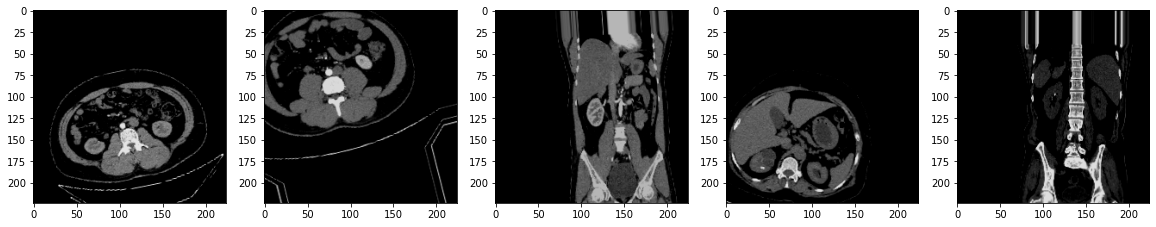

In [24]:
f, ax = plt.subplots(nrows= 1, ncols=5, figsize = (20,4))
for i in range(0,5):
    image = images[i]
    plt.sca(ax[i])
    plt.imshow(image)
plt.show()

In [25]:
#opt = SGD(learning_rate=learnR, momentum=0.5, decay=learnR / Epoch)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.8)
opt = keras.optimizers.SGD(learning_rate=lr_schedule)


In [22]:
model = models.Sequential([
    layers.Conv2D(filters=96, kernel_size=(3,3), activation='relu', input_shape=(500,500,3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=258, kernel_size=(3,3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(384, (3, 3), activation='relu'),
    #layers.BatchNormalization(),
    #layers.MaxPooling2D((2, 2))
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 498, 498, 96)      2688      
                                                                 
 batch_normalization_3 (Batc  (None, 498, 498, 96)     384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 249, 249, 96)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 249, 249, 128)     110720    
                                                                 
 batch_normalization_4 (Batc  (None, 249, 249, 128)    512       
 hNormalization)                                                 
                                                      

In [30]:
from tensorflow.keras.applications import VGG19
base = VGG19(weights='imagenet',
                  include_top=False, #removing the dense layers
                  input_shape=(150,150,3))


model = models.Sequential()
model.add(base)

In [31]:
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(120, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='relu'))
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 120)               30840     
                                                                 
 dropout_7 (Dropout)         (None, 120)               0         
                                                                 
 dense_10 (Dense)            (None, 10)               

In [32]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15772771257109466568
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3221225472
locality {
  bus_id: 1
  links {
  }
}
incarnation: 682129780465531240
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [28]:
callback = EarlyStopping('loss', patience=3)
class_weight = {0:1, 1:4}

In [33]:
history = model.fit(train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training',
                                                    shuffle=True),
                    steps_per_epoch=200,                                
                    epochs=Epoch,
                    batch_size=batch_size,
                    #class_weight = class_weight,
                    #callbacks = [callback],
                    #verbose = 0,
                    validation_data=train_datagen.flow_from_directory(train_dir,
                                                        target_size=(150, 150),
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        subset='validation',
                                                        shuffle=True))

Found 6506 images belonging to 2 classes.
Found 1626 images belonging to 2 classes.
Epoch 1/50
200/200 [==============================] - 170s 832ms/step - loss: nan - accuracy: 0.7433 - val_loss: nan - val_accuracy: 0.7417
Epoch 2/50
200/200 [==============================] - 136s 680ms/step - loss: nan - accuracy: 0.7437 - val_loss: nan - val_accuracy: 0.7417
Epoch 3/50
200/200 [==============================] - 157s 787ms/step - loss: nan - accuracy: 0.7433 - val_loss: nan - val_accuracy: 0.7417
Epoch 4/50
200/200 [==============================] - 218s 1s/step - loss: nan - accuracy: 0.7428 - val_loss: nan - val_accuracy: 0.7417
Epoch 5/50
 65/200 [========>.....................] - ETA: 2:58 - loss: nan - accuracy: 0.7472

KeyboardInterrupt: 

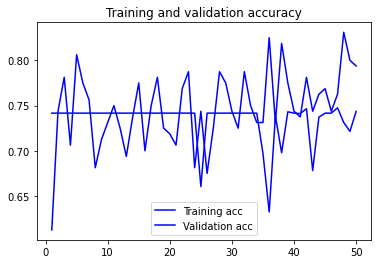

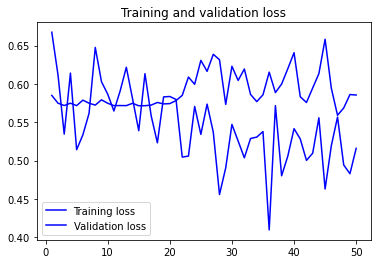

In [25]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
#plotting training and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [40]:
y_pred= model.predict(np.array(y_test))

y_true= y_test.classes

cnf_matrix= confusion_matrix(y_true,y_pred.argmax(axis=1))
print('Confusion Matrix:\n',cnf_matrix)

ValueError: in user code:

    File "d:\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "d:\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "d:\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
        return self(x, training=False)
    File "d:\Anaconda\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "d:\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\input_spec.py", line 228, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential" (type Sequential).
    
    Input 0 of layer "conv2d" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 1)
    
    Call arguments received by layer "sequential" (type Sequential):
      • inputs=tf.Tensor(shape=(None, 1), dtype=int64)
      • training=False
      • mask=None


In [42]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(data_dir,
                                                  target_size=(224, 224),
                                                  batch_size=100,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 8244 images belonging to 3 classes.
